In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import defaultdict
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot
from wordcloud import WordCloud, STOPWORDS

In [3]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [4]:
df = pd.read_json(r"C:\Users\dines\Downloads\Musical_Instruments_5.json\Musical_Instruments_5.json", lines=True)
df.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...        5   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

# Checking null values and filling with "missing" string

In [5]:
df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [6]:
df.fillna('missing', inplace=True)

# Checking empty string in all over columns

In [7]:
for i in df.columns:
    print(df[df[i] == ''][i])

Series([], Name: reviewerID, dtype: object)
Series([], Name: asin, dtype: object)
Series([], Name: reviewerName, dtype: object)
Series([], Name: helpful, dtype: object)
2927    
4401    
8739    
9175    
9306    
9313    
9342    
Name: reviewText, dtype: object
Series([], Name: overall, dtype: int64)
Series([], Name: summary, dtype: object)
Series([], Name: unixReviewTime, dtype: int64)
Series([], Name: reviewTime, dtype: object)


# Total 7 rows of "reviewText" data is missing. So, we can remove all column rows which is having null values in "reviewText"

In [8]:
df = df[df['reviewText']!='']

In [9]:
# newdf.head()

# We do not required "reviewerID" and "asin" to build model

In [10]:
df.drop(['reviewerID', 'asin'], axis=1, inplace=True)

In [11]:
df.head()

reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...        5   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

In [12]:
df['overall'].unique()

array([5, 3, 4, 2, 1], dtype=int64)

In [13]:
df['overall'].iplot(kind='hist',bins=5, xTitle='Ratings', yTitle='Count', title='Reviews Count', color='black')

# Need to define the sentiment weather it is positive, negitive and neutral based on the overall rating over 5

In [14]:
df['sentiments'] = df['overall'].apply(lambda x: 'positive' if x==5 or x==4 else ('negitive' if x==1 or x==2 else 'neutral'))

In [15]:
df.head()

reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...        5   

                                 summary  unixReviewTime   reviewTime  \
0                                   good      1393545600  02 28, 2014   
1                                   Jake      1363392000  03 16, 2013   
2                   It Does The Job Well      1377648000  08 28, 2013   
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014   
4  No more pops when I record my vocals.      1392940800  02 21, 2014   

  sentiments  
0   positive  
1   positive  
2   positive  
3   positive  
4   positive

In [16]:
df['sentiments'].value_counts()

positive    9015
neutral      772
negitive     467
Name: sentiments, dtype: int64

# Ploting the sentiment

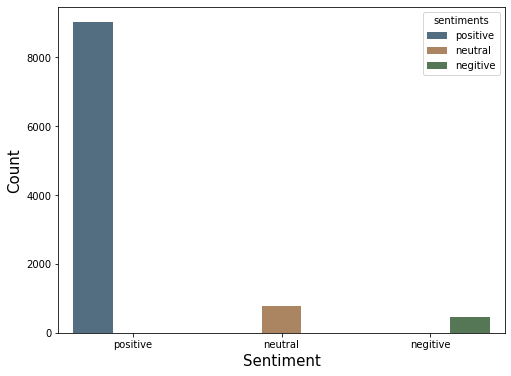

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['sentiments'], hue=df['sentiments'], saturation=0.3)
# plt.legend(('positive', 'neutral', 'negitive'), ncol = 3)
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

# splitting the "reviewTime"

In [18]:
df['Year'] = df['reviewTime'].apply(lambda x: str(x).split(',')[-1])
df['Day'] = df['reviewTime'].apply(lambda x: str(x).split(',')[0].split()[0])
df['Month'] = df['reviewTime'].apply(lambda x: str(x).split(',')[0].split()[1])

In [19]:
def helpful(x):
    a, b = x
    try:
        return float("{:.2f}".format(a/b))
    except:
        return float(0.0)

In [20]:
df['helpful_rate'] = df['helpful'].apply(helpful)

In [21]:
df.drop(['helpful', 'reviewTime', 'unixReviewTime'], axis=1, inplace=True)

In [22]:
df.head()

reviewerName  \
0  cassandra tu "Yeah, well, that's just like, u...   
1                                              Jake   
2                     Rick Bennette "Rick Bennette"   
3                         RustyBill "Sunday Rocker"   
4                                     SEAN MASLANKA   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...        5   

                                 summary sentiments   Year Day Month  \
0                                   good   positive   2014  02    28   
1                                   Jake   positive   2013  03    16   
2                   It Does The Job Well   positive   2013  08    28   
3          GOOD WINDSCREEN FOR THE MONEY   positive   2014  02    14   
4  No more pops when I record my vocals.   positive   2014  02    21   

   helpful_rate  
0          0.00  
1          0.93  
2          1.00  
3          0.00  
4          0.00

In [23]:
newdf = df.copy()

In [24]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [25]:
newdf['reviews']=newdf['reviewText'].apply(lambda x:review_cleaning(x))
newdf.head()

reviewerName  \
0  cassandra tu "Yeah, well, that's just like, u...   
1                                              Jake   
2                     Rick Bennette "Rick Bennette"   
3                         RustyBill "Sunday Rocker"   
4                                     SEAN MASLANKA   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...        5   

                                 summary sentiments   Year Day Month  \
0                                   good   positive   2014  02    28   
1                                   Jake   positive   2013  03    16   
2                   It Does The Job Well   positive   2013  08    28   
3          GOOD WINDSCREEN FOR THE MONEY   positive   2014  02    14   
4  No more pops when I record my vocals.   positive   2014  02    21   

   helpful_rate                                            reviews  
0          0.00  not much to write about here but it does exact...  
1          0.93  the product does exactly as it should and is q...  
2          1.00  the primary job of this device is to block the...  
3          0.00  nice windscreen protects my mxl mic and preven...  
4          0.00  this pop filter is great it looks and performs...

In [26]:
stwords = stopwords.words('english')

In [27]:
newdf['reviews'] = newdf['reviews'].apply(lambda x: " ".join(i for i in str(x).split() if i not in stwords))

In [28]:
newdf.drop(['reviewText', 'overall'], axis=1, inplace=True)

In [29]:
newdf.head()

reviewerName  \
0  cassandra tu "Yeah, well, that's just like, u...   
1                                              Jake   
2                     Rick Bennette "Rick Bennette"   
3                         RustyBill "Sunday Rocker"   
4                                     SEAN MASLANKA   

                                 summary sentiments   Year Day Month  \
0                                   good   positive   2014  02    28   
1                                   Jake   positive   2013  03    16   
2                   It Does The Job Well   positive   2013  08    28   
3          GOOD WINDSCREEN FOR THE MONEY   positive   2014  02    14   
4  No more pops when I record my vocals.   positive   2014  02    21   

   helpful_rate                                            reviews  
0          0.00  much write exactly supposed filters pop sounds...  
1          0.93  product exactly quite affordablei realized dou...  
2          1.00  primary job device block breath would otherwis...  
3          0.00  nice windscreen protects mxl mic prevents pops...  
4          0.00  pop filter great looks performs like studio fi...

In [30]:
newdf['Year'].iplot(kind='hist', xTitle='Years', yTitle='Count', bins=50, color='green')

In [31]:
newdf.groupby(['sentiments'])['helpful_rate'].mean().reset_index()

sentiments  helpful_rate
0   negitive      0.307559
1    neutral      0.275687
2   positive      0.259946

Text(0.5, 0, 'Sentiments')

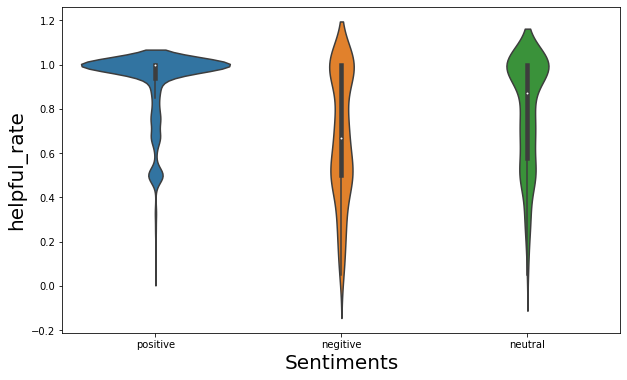

In [32]:
helpful_rate = newdf[newdf['helpful_rate']!=0.0]

plt.figure(figsize=(10, 6))

sns.violinplot(x=helpful_rate['sentiments'], y=helpful_rate['helpful_rate'],)
plt.ylabel('helpful_rate',fontsize=20)
plt.xlabel('Sentiments', fontsize=20)

<Figure size 720x720 with 0 Axes>

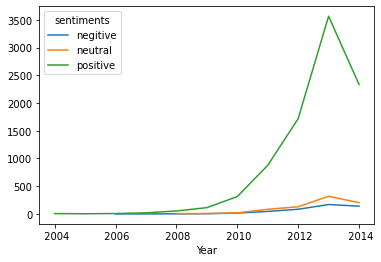

In [33]:
plt.figure(figsize=(10, 10))
newdf.groupby(['Year', 'sentiments'])['sentiments'].count().unstack().plot(legend=True)
# a = newdf.groupby(['Year', 'sentiments'])['sentiments'].count().unstack().reset_index()
# sns.lineplot(x=a['Year'], y = a['positive'])
# sns.lineplot(x=a['Year'], y = a['negitive'])
# sns.lineplot(x=a['Year'], y = a['neutral'])
plt.show()

# From the plot we can clearly see the rise in positive reviews from 2010. 
# Reaching its peak around 2013 and there is a dip in 2014, 
# All the review rates were dropped at this time. Negative and neutral reviews are very low as compared to the positive reviews. 
# Our second assumption is wrong !

In [34]:
newdf.head()

reviewerName  \
0  cassandra tu "Yeah, well, that's just like, u...   
1                                              Jake   
2                     Rick Bennette "Rick Bennette"   
3                         RustyBill "Sunday Rocker"   
4                                     SEAN MASLANKA   

                                 summary sentiments   Year Day Month  \
0                                   good   positive   2014  02    28   
1                                   Jake   positive   2013  03    16   
2                   It Does The Job Well   positive   2013  08    28   
3          GOOD WINDSCREEN FOR THE MONEY   positive   2014  02    14   
4  No more pops when I record my vocals.   positive   2014  02    21   

   helpful_rate                                            reviews  
0          0.00  much write exactly supposed filters pop sounds...  
1          0.93  product exactly quite affordablei realized dou...  
2          1.00  primary job device block breath would otherwis...  
3          0.00  nice windscreen protects mxl mic prevents pops...  
4          0.00  pop filter great looks performs like studio fi...

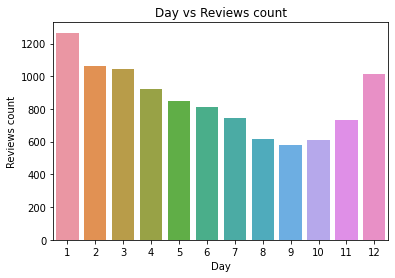

In [35]:
#Creating a dataframe
day=pd.DataFrame(newdf.groupby('Day')['reviews'].count()).reset_index()
day['Day']=day['Day'].astype('int64')
day.sort_values(by=['Day'])

#Plotting the graph
sns.barplot(x="Day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

# Creating few more features for text analysis¶
# Now, let's create polarity, review length and word count

# Polarity: We use Textblob for for figuring out the rate of sentiment . It is between [-1,1] where -1 is negative and 1 is positive polarity

# Review length: length of the review which includes each letters and spaces

# Word length: This measures how many words are there in review

In [36]:
TextBlob(newdf['reviews'][0]).sentiment

Sentiment(polarity=0.32499999999999996, subjectivity=0.44166666666666665)

In [37]:
newdf['polarity'] = newdf['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
newdf['rev_length'] = newdf['reviews'].astype(str).apply(len)
newdf['word_lenth'] = newdf['reviews'].apply(lambda x: len(str(x).split()))

In [38]:
newdf.head()

reviewerName  \
0  cassandra tu "Yeah, well, that's just like, u...   
1                                              Jake   
2                     Rick Bennette "Rick Bennette"   
3                         RustyBill "Sunday Rocker"   
4                                     SEAN MASLANKA   

                                 summary sentiments   Year Day Month  \
0                                   good   positive   2014  02    28   
1                                   Jake   positive   2013  03    16   
2                   It Does The Job Well   positive   2013  08    28   
3          GOOD WINDSCREEN FOR THE MONEY   positive   2014  02    14   
4  No more pops when I record my vocals.   positive   2014  02    21   

   helpful_rate                                            reviews  polarity  \
0          0.00  much write exactly supposed filters pop sounds...  0.325000   
1          0.93  product exactly quite affordablei realized dou...  0.014286   
2          1.00  primary job device block breath would otherwis...  0.167500   
3          0.00  nice windscreen protects mxl mic prevents pops...  0.333333   
4          0.00  pop filter great looks performs like studio fi...  0.800000   

   rev_length  word_lenth  
0         150          23  
1         342          52  
2         295          43  
3         148          20  
4         107          16

In [39]:
newdf['polarity'].iplot(kind='hist',bins=50, xTitle='Polarity', yTitle='Count', linecolor='black', title='Sentiment Polarity Distribution')


In [40]:
newdf['rev_length'].iplot(kind='hist', bins=100, xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

In [41]:
newdf['word_lenth'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

# N-gram analysis
# Welcome to the deep text analysis. Here we will be using ngrams to analyse the text, based on it's sentiment

# Monogram analysis
# Here we will plot most frequent one word in reviews based on sentiments

<!-- N-gram analysis
Welcome to the deep text analysis. Here we will be using ngrams to analyse the text, based on it's sentiment

Monogram analysis
Here we will plot most frequent one word in reviews based on sentiments -->

In [42]:
review_pos = newdf[newdf["sentiments"]=='positive'].dropna()
review_neu = newdf[newdf["sentiments"]=='neutral'].dropna()
review_neg = newdf[newdf["sentiments"]=='negitive'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(10), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(10), 'red')
from plotly.subplots import make_subplots
# Creating two subplots
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

# As we see, the words doen't match with the sentiment except few. Through monogram we can't judge a sendiment based on one word. So let's try with frequent two words

# Bigram analysis¶
# Here we will plot most frequent two words in reviews based on sentiments

In [43]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

C:\Users\dines\anaconda3\envs\newenv2\lib\site-packages\plotly\tools.py:464: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Here we can get a clear idea about the sentiments from the bi-words

# Trigram analysis
# Here we will plot most frequent three words in reviews based on sentiments

In [44]:
freq_dict = defaultdict(int)
for sent in review_pos['reviews']:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1

fd_sorted = pd.DataFrame(sorted(freq_dict.items(), reverse=True, key=lambda x: x[1]))
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10),'red')

freq_dict = defaultdict(int)
for sent in review_neu['reviews']:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1

fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True), columns=["word", "wordcount"])
trace1 = horizontal_bar_chart(fd_sorted.head(10), 'green')

freq_dict = defaultdict(int)
for sent in review_neg['reviews']:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1

fd_sorted = pd.DataFrame(sorted(freq_dict.items(), reverse=True, key=lambda x: x[1]), columns=["word", "wordcount"])
trace2 = horizontal_bar_chart(fd_sorted.head(10), 'yellow')

In [45]:
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

# Wordcloud-Positive reviews

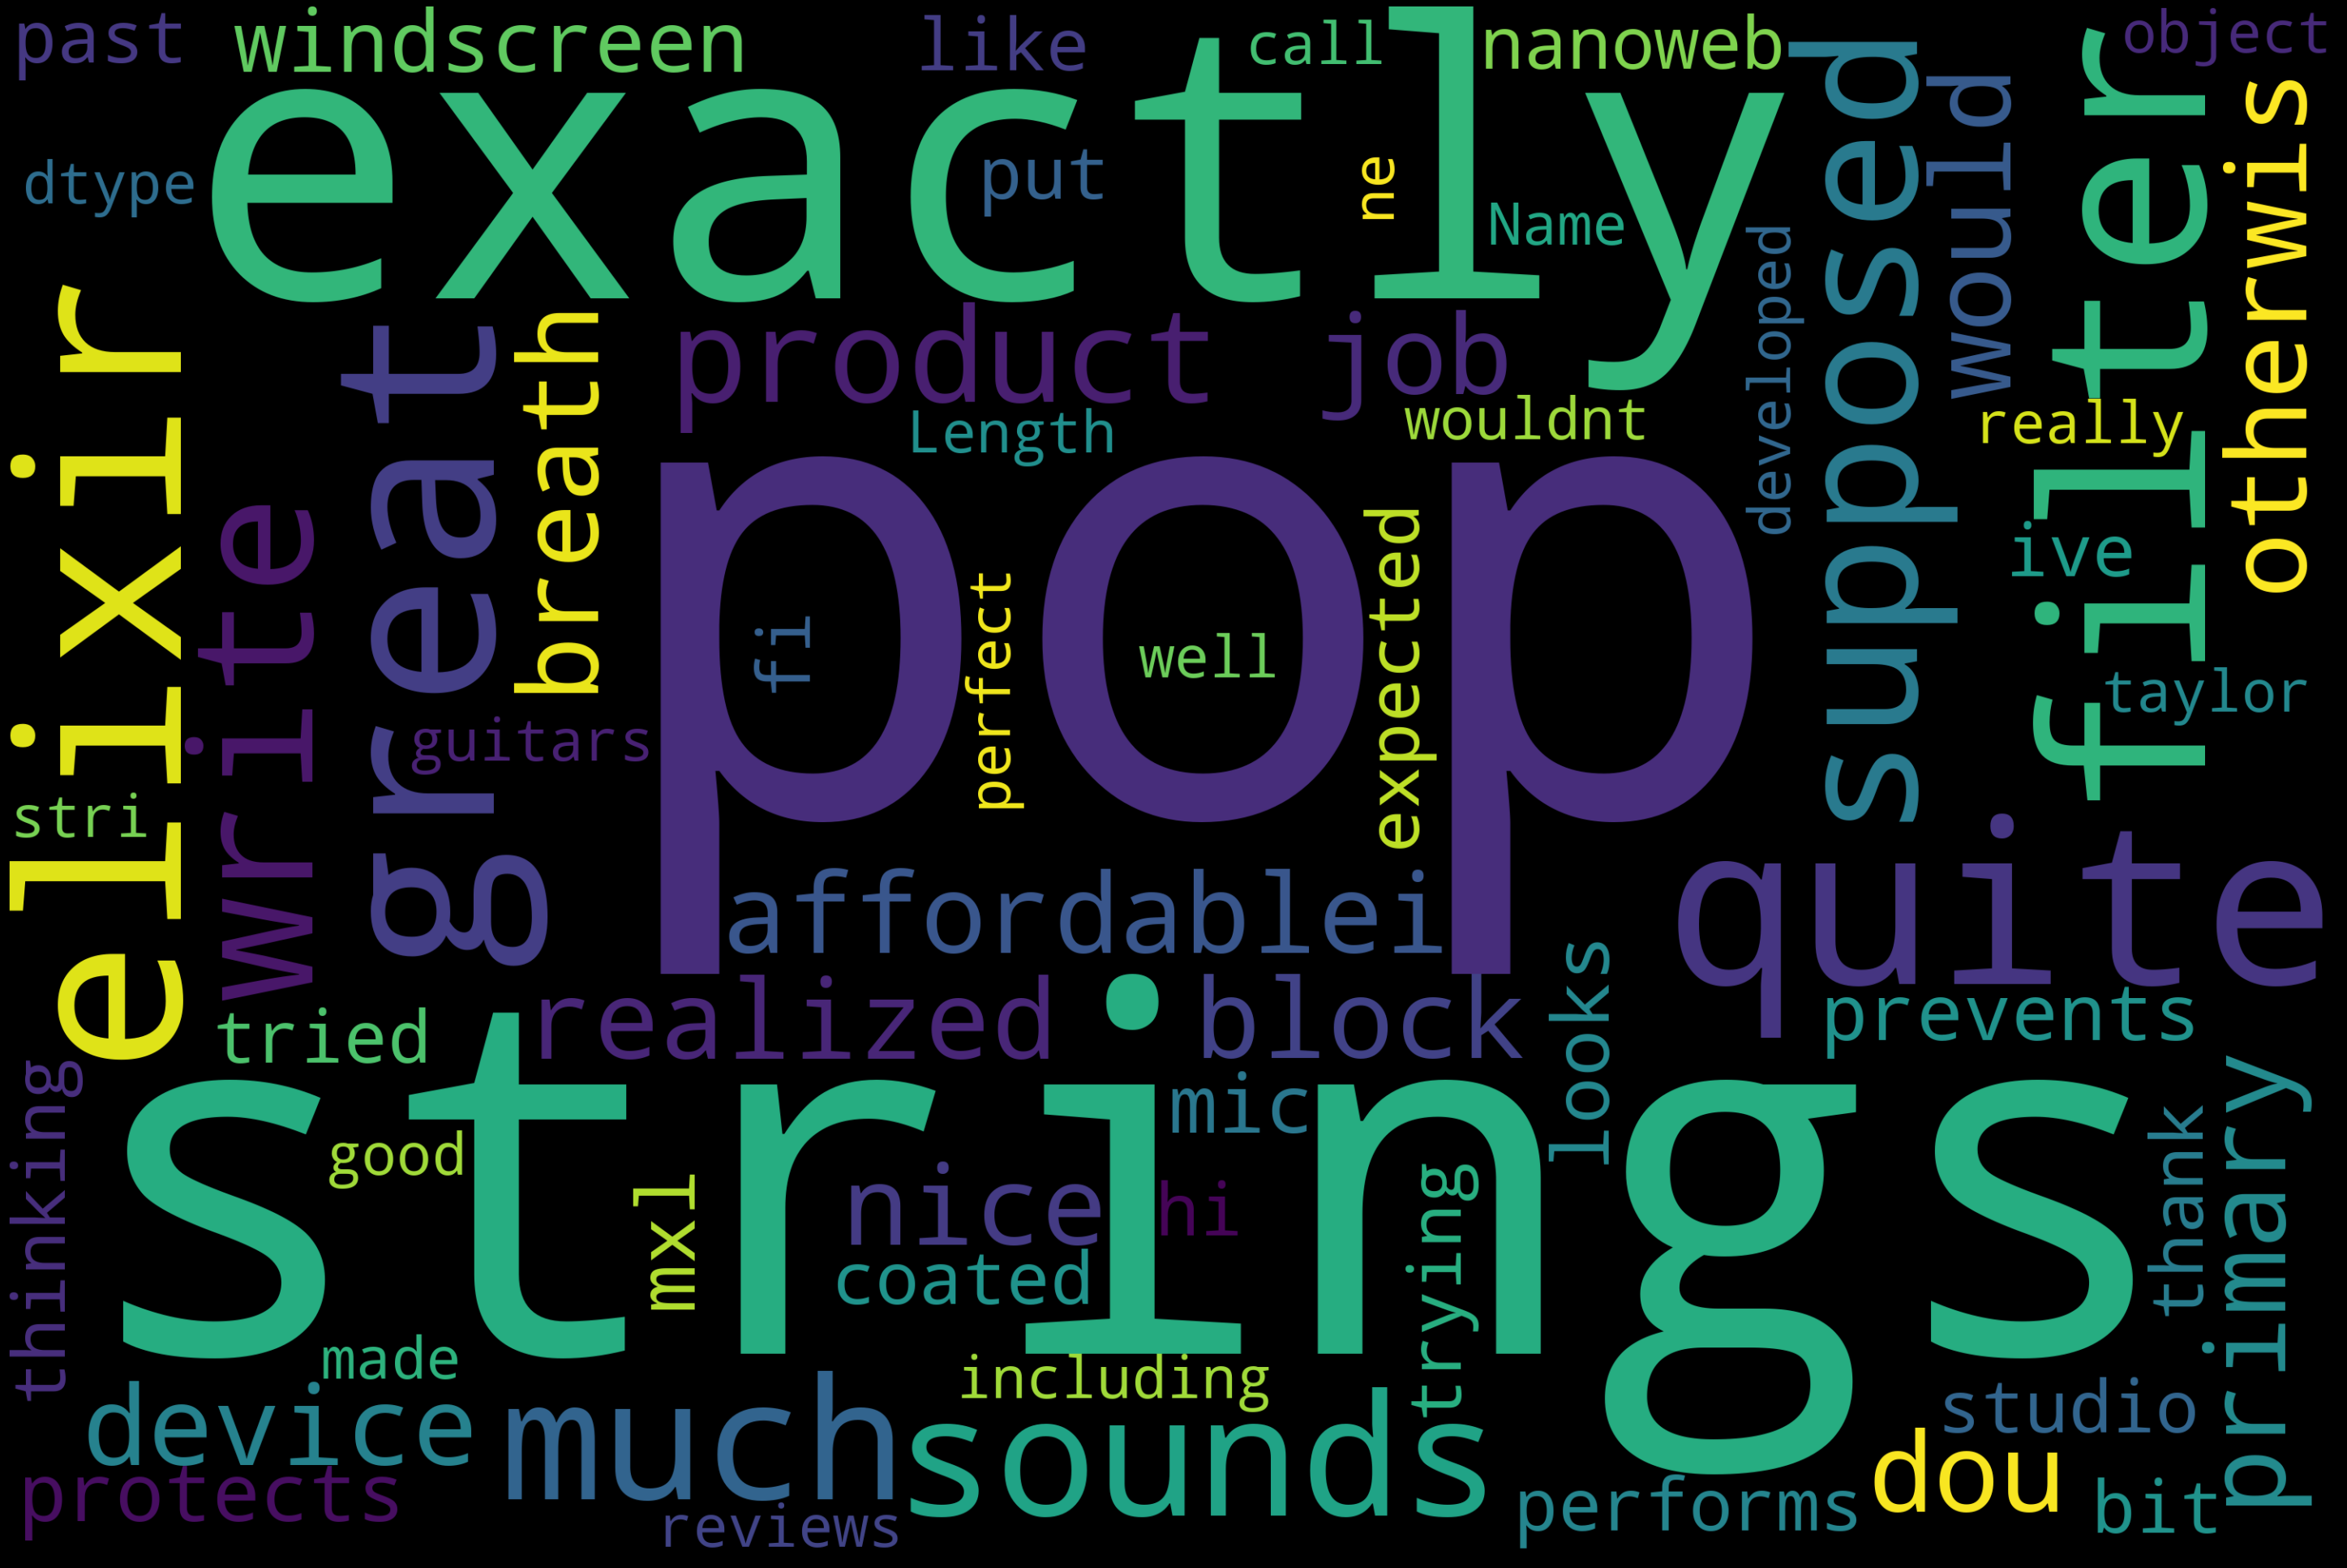

In [46]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stwords).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Wordcloud-Neutral reviews

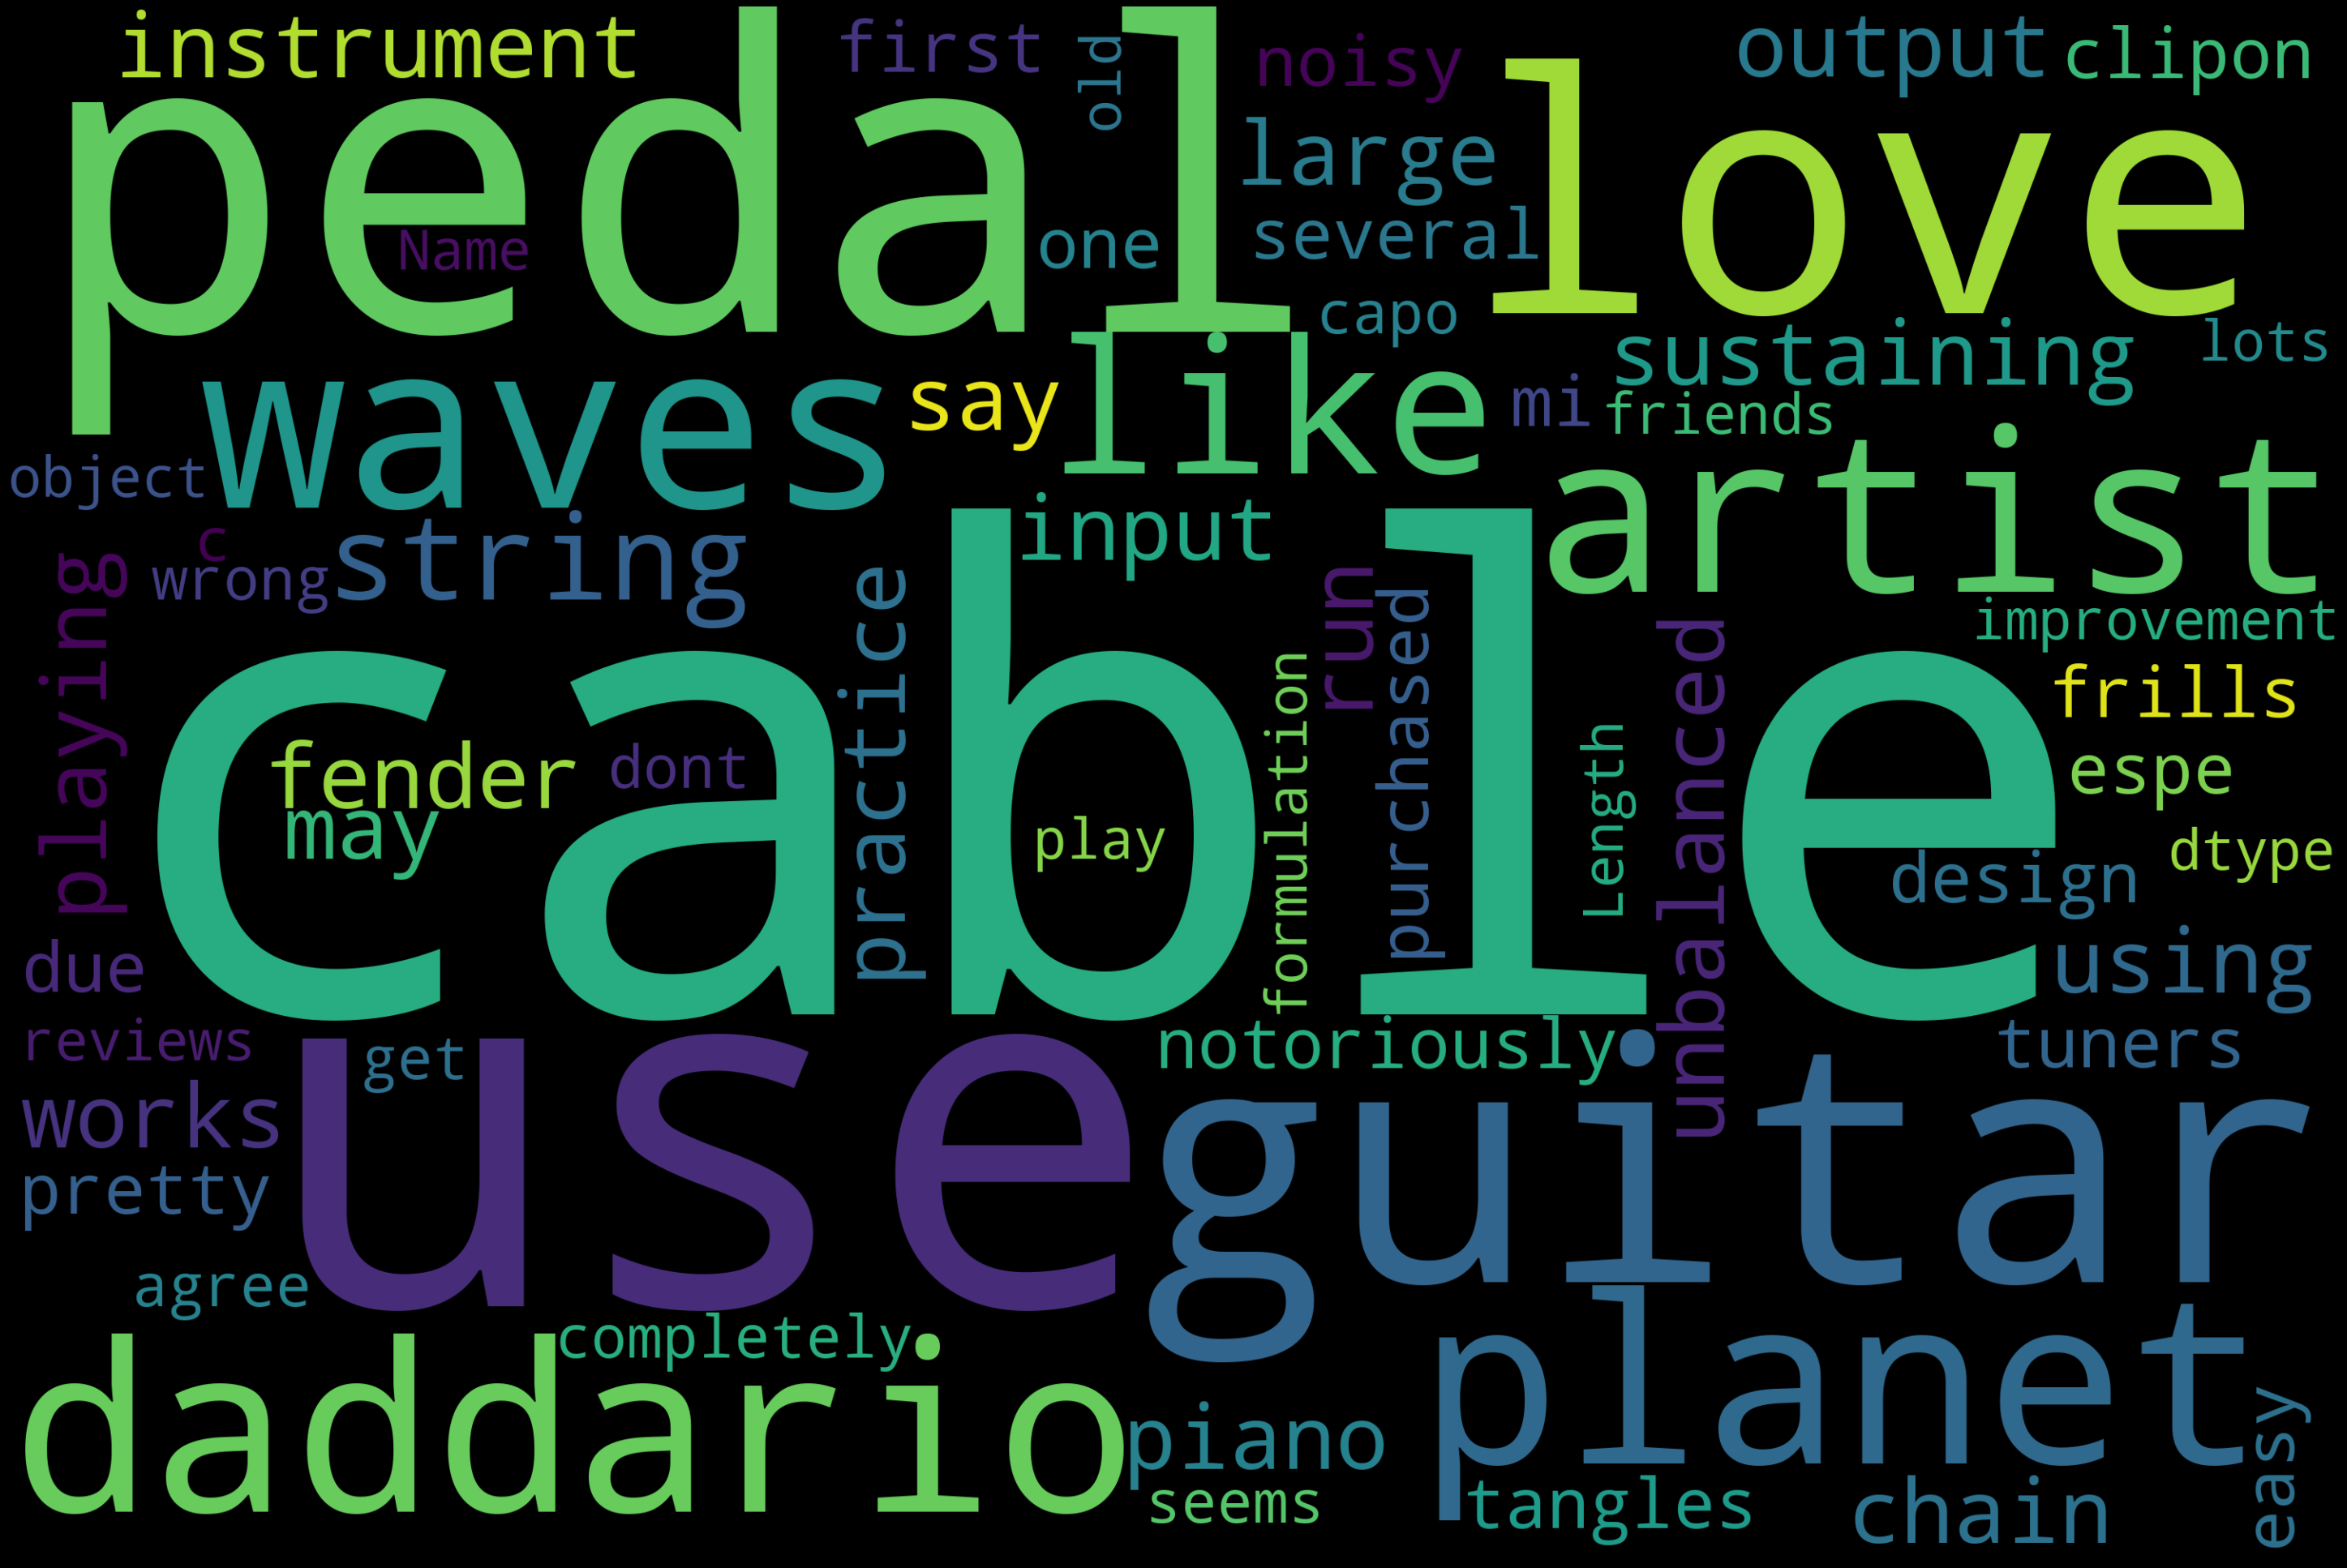

In [47]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stwords).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Wordcloud-Neutral reviews

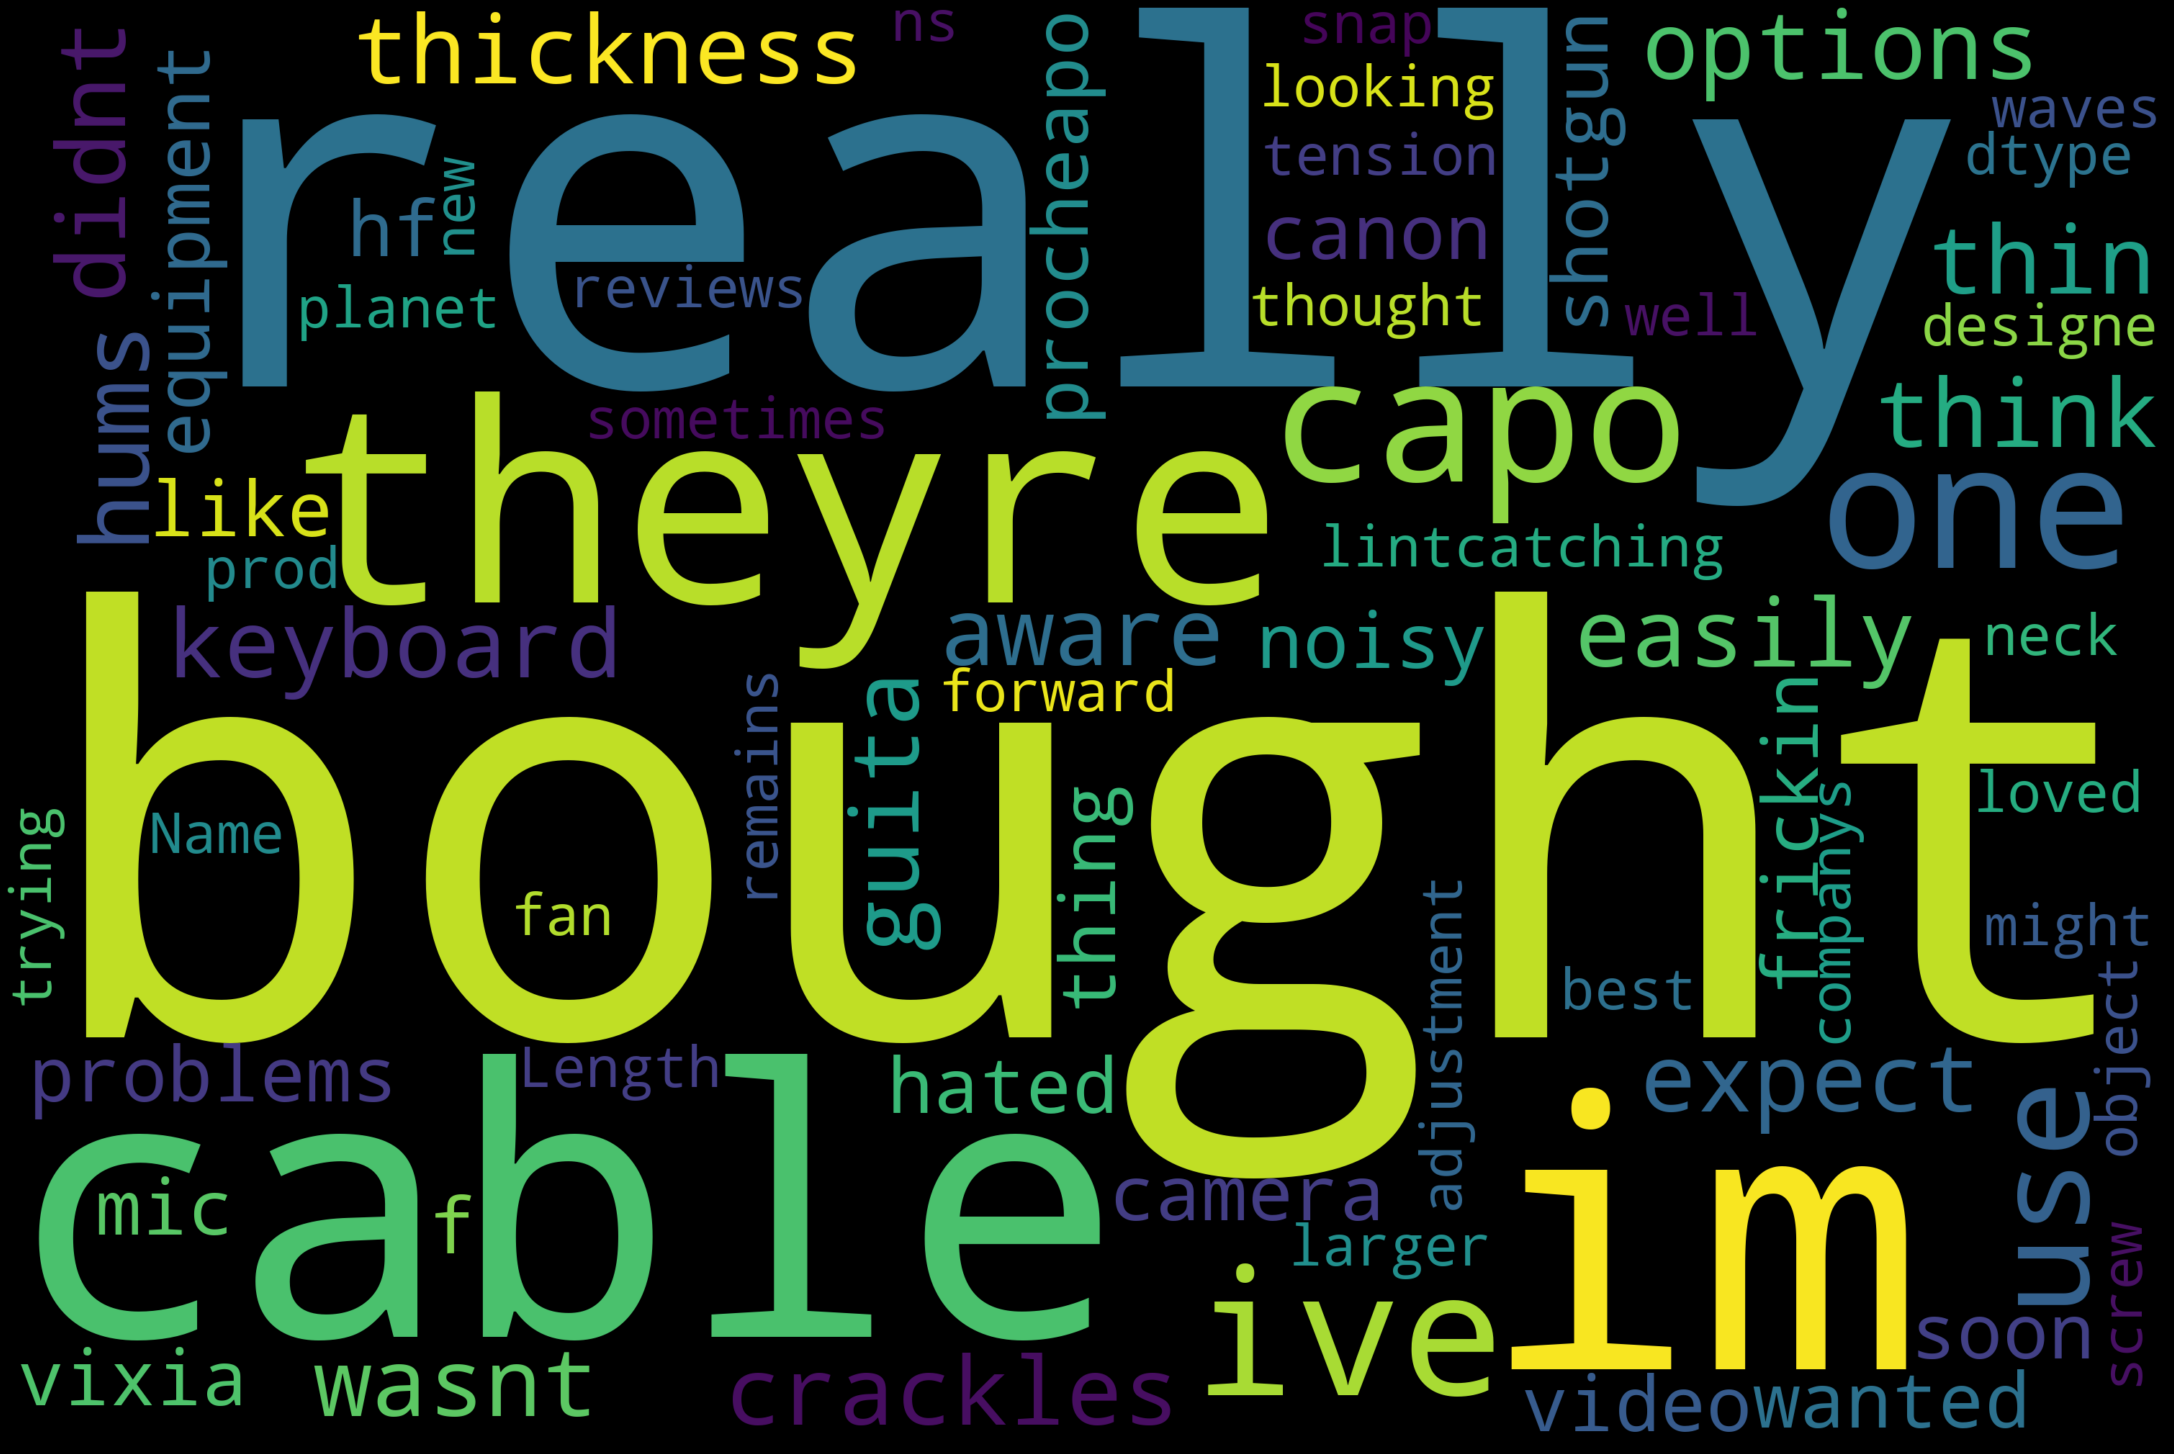

In [48]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stwords).generate(str(text))
fig = plt.figure(
    figsize = (30, 40),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [49]:
newdf.head()

reviewerName  \
0  cassandra tu "Yeah, well, that's just like, u...   
1                                              Jake   
2                     Rick Bennette "Rick Bennette"   
3                         RustyBill "Sunday Rocker"   
4                                     SEAN MASLANKA   

                                 summary sentiments   Year Day Month  \
0                                   good   positive   2014  02    28   
1                                   Jake   positive   2013  03    16   
2                   It Does The Job Well   positive   2013  08    28   
3          GOOD WINDSCREEN FOR THE MONEY   positive   2014  02    14   
4  No more pops when I record my vocals.   positive   2014  02    21   

   helpful_rate                                            reviews  polarity  \
0          0.00  much write exactly supposed filters pop sounds...  0.325000   
1          0.93  product exactly quite affordablei realized dou...  0.014286   
2          1.00  primary job device block breath would otherwis...  0.167500   
3          0.00  nice windscreen protects mxl mic prevents pops...  0.333333   
4          0.00  pop filter great looks performs like studio fi...  0.800000   

   rev_length  word_lenth  
0         150          23  
1         342          52  
2         295          43  
3         148          20  
4         107          16

In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
lbEncoder = LabelEncoder()
y = lbEncoder.fit_transform(newdf['sentiments'])

In [52]:
# newdf['sentiments'].value_counts()

In [53]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))

In [54]:
X = tfidf_vectorizer.fit_transform(newdf['reviews'])

In [55]:
X.shape

(10254, 5000)

In [165]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [64]:
Counter(y)

Counter({2: 9015, 1: 772, 0: 467})

In [68]:
X_res, y_res = SMOTE().fit_resample(X, y)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

In [73]:
corpus = []
for i in newdf['reviews']:
    rev = re.sub('[^a-zA-Z]', ' ', i)
    rev = [word for word in rev.split() if word not in stwords]
    rev = ' '.join(rev)
    corpus.append(rev)

In [83]:
lr = LogisticRegression(random_state=0)
svc = SVC()
dtc = DecisionTreeClassifier()
nb = BernoulliNB()
knc = KNeighborsClassifier()

In [107]:
models = {'LogisticRegression': lr,  'SVC': svc, 'DecisionTreeClassifier': dtc, 'BernoulliNB': nb, 'KNeighborsClassifier': knc}

for i, j in zip(list(models.keys()), list(models.values())):
    print("{} Test Accuracy: {}".format(i, cross_val_score(j, X, y, cv=10, scoring ='accuracy').mean()))

LogisticRegression Test Accuracy: 0.8798517567631817
SVC Test Accuracy: 0.8795591689250226
DecisionTreeClassifier Test Accuracy: 0.809245756668093
BernoulliNB Test Accuracy: 0.8058245614035089
KNeighborsClassifier Test Accuracy: 0.8582995293110827


In [140]:
# grid = {'C': np.logspace(-4, 4, 50),
#        'penality': ['11', '12']}
# clf = GridSearchCV(LogisticRegression(C=0.0001, random_state=0), param_grid=grid, cv=5, verbose=0, n_jobs=-1)
# clf.fit(X_train, y_train)

In [141]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.93


C:\Users\dines\anaconda3\envs\newenv2\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



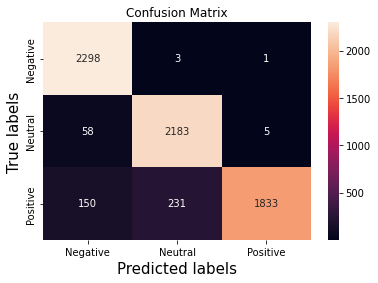

<Figure size 720x720 with 0 Axes>

In [164]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15) 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative','Neutral','Positive'],fontsize=10)
ax.yaxis.set_ticklabels(['Negative','Neutral','Positive'], fontsize=10)
plt.show()

In [169]:
print("\n",classification_report(y_test, y_pred))


               precision    recall  f1-score   support

           0       0.92      1.00      0.96      2302
           1       0.90      0.97      0.94      2246
           2       1.00      0.83      0.90      2214

    accuracy                           0.93      6762
   macro avg       0.94      0.93      0.93      6762
weighted avg       0.94      0.93      0.93      6762



In [182]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

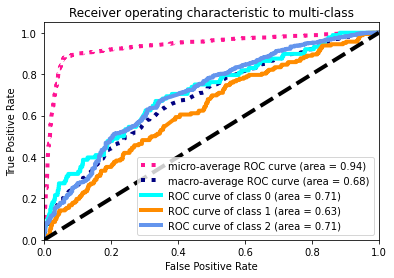

In [183]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()